In [1]:
import numpy as np
import scipy.stats as st
import warnings
import matplotlib.pyplot as plt

import OptimalSequence

In [2]:
number_samples = 200

# Generate data
### Using truncnormal 
between 0 and 20 with `mean=8`, `sigma=2`

In [3]:
upper_limit = 20
lower_limit = 0

upper_bound = (upper_limit - 8) / 2
lower_bound = (lower_limit - 8) / 2

mu = 8
sigma = 2

data = st.truncnorm.rvs(lower_bound, upper_bound, loc=8, scale=2, size=number_samples)
print("Bounds: (%3.1f %3.1f) mean=%3.1f; sigma=%3.1f" %(min(data), max(data), np.mean(data), np.std(data)))

Bounds: (3.1 14.3) mean=8.1; sigma=2.0


# Funcion to compute the cost 
### Using TOPtimal to compute the sequence

In [10]:
def compute_cost(cdf, print_sequence=False):
    handler = OptimalSequence.TOptimalSequence(lower_limit, upper_limit, cdf, discret_samples=500)
    sequence = handler.compute_request_sequence()
    arg = [lower_bound, upper_bound]
    if print_sequence:
        print(sequence)

    # Compute the expected makespan (MS)
    MS = sum([sequence[i+1]*(1-st.truncnorm.cdf(sequence[i], loc=mu, scale=sigma, *arg))
              for i in range(len(sequence)-1)])
    MS += sequence[0]
    # MS = sum([sequence[i+1]*cdf(sequence[i]) for i in range(len(sequence)-1)])
    return MS

# Fitting the data using a list of distributions

In [5]:
dist_list = [        
            st.alpha,st.beta,st.cosine,st.dgamma,st.dweibull,st.exponnorm,st.exponweib,
            st.exponpow,st.genpareto,st.gamma,st.halfnorm,st.invgauss,st.invweibull,
            st.laplace,st.loggamma,st.lognorm,st.lomax,st.maxwell,st.norm,st.pareto,
            st.pearson3,st.rayleigh,st.rice,st.truncexpon,st.truncnorm,st.uniform,
            st.weibull_min,st.weibull_max
        ]

In [6]:
best_fit = [np.inf, 0, 0, 0, [0, 0, 0]]
worse_fit = [0, 0, 0, 0, [0, 0, 0]]
for i in range(100):
    data = st.truncnorm.rvs(lower_bound, upper_bound, loc=mu, scale=sigma, size=number_samples)

    # Best holders
    best_distribution = -1
    best_params = (0.0, 1.0)
    best_sse = np.inf
    best_cost = -1

    norm_distribution = []
    truncnorm_distribution = []

    # Estimate distribution parameters from data
    for distribution in dist_list:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Compute the histogram for the data
                y, x = np.histogram(data, bins=100, density=True)
                x = (x + np.roll(x, -1))[:-1] / 2.0

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                if distribution.name == "norm" or distribution.name == "truncnorm":
                    arg = params[:-2]
                    cdf = lambda val: distribution.cdf(val, loc=params[-2], scale=params[-1], *arg)
                    cost = compute_cost(cdf)
                    
                if distribution.name == "norm":
                    norm_distribution = [sse, params, cost]

                if distribution.name == "truncnorm":
                    truncnorm_distribution = [sse, params, cost]

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                    
                    arg = params[:-2]
                    cdf = lambda val: distribution.cdf(val, loc=params[-2], scale=params[-1], *arg)
                    best_cost = compute_cost(cdf)

        except Exception:
            pass

    #print("%s \t %f \t %f \t %s" %(best_distribution.name, best_sse, best_cost, best_params))
    #print("Norm \t %f \t %f \t %s" %(norm_distribution[0], norm_distribution[2], norm_distribution[1]))
    #print("TruncNorm \t %f \t %f \t %s" %(truncnorm_distribution[0], truncnorm_distribution[2], truncnorm_distribution[1]))
    #print("-----------------")
    if np.abs(best_cost - norm_distribution[2]) < np.abs(best_fit[0] - best_fit[4][2]) and best_distribution.name != "norm":
        best_fit = [best_cost, best_sse, best_distribution, best_params, norm_distribution]
    if np.abs(best_cost - norm_distribution[2]) > np.abs(worse_fit[0] - worse_fit[4][2]):
        worse_fit = [best_cost, best_sse, best_distribution, best_params, norm_distribution]

# Plot data
### worse and best fit compared to the norm fit
* the best fit and 
* the norm distributions

Best fit cost 11.946442 
Norm cost 11.946449 (diff -0.000007)


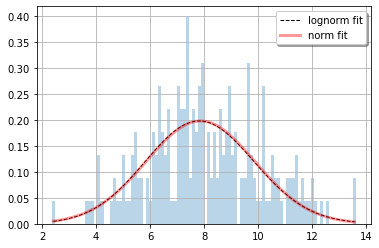

In [7]:
# Best fit

print("Best fit cost %f \nNorm cost %f (diff %f)" %(best_fit[0], best_fit[4][2], best_fit[0]-best_fit[4][2]))
fig, ax = plt.subplots(1, 1)
# plot the best fit line
best_distribution = best_fit[2]
best_params = best_fit[3]
ax.plot(x, best_distribution.pdf(x, loc=best_params[-2], scale=best_params[-1], *best_params[:-2]),
        'k--', lw=1, alpha=1.0, label='%s fit' %(best_distribution.name))
# plot the normal line
ax.plot(x, st.norm.pdf(x, *best_fit[4][1]),
        'r-', lw=3, alpha=0.4, label='norm fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()

Worse fit cost 858.043697 
Norm cost 11.942383 (diff 846.101313)
[0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0, 1.04, 1.08, 1.12, 1.16, 1.2, 1.24, 1.28, 1.32, 1.36, 1.4000000000000001, 1.44, 1.48, 1.52, 1.56, 1.6, 1.6400000000000001, 1.68, 1.72, 1.76, 1.8, 1.84, 1.8800000000000001, 1.92, 1.96, 2.0, 2.04, 2.08, 2.12, 2.16, 2.2, 2.24, 2.2800000000000002, 2.32, 2.36, 2.4, 2.44, 2.48, 2.52, 2.56, 2.6, 2.64, 2.68, 2.72, 2.7600000000000002, 2.8000000000000003, 2.84, 2.88, 2.92, 2.96, 3.0, 3.04, 3.08, 3.12, 3.16, 3.2, 3.24, 3.2800000000000002, 3.3200000000000003, 3.36, 3.4, 3.44, 3.48, 3.52, 3.56, 3.6, 3.64, 3.68, 3.72, 3.7600000000000002, 3.8000000000000003, 3.84, 3.88, 3.92, 3.96, 4.0, 4.04, 4.08, 4.12, 4.16, 4.2, 4.24, 4.28, 4.32, 4.36, 4.4, 4.44, 4.48, 4.5200000000000005, 4.5600000000000005, 4.6000000000000005, 4.64, 4.68, 4.72, 4.76, 4.8, 4.84, 4.88, 4.92, 4.96, 5.0, 5.04, 5.08, 5.12, 5.16,

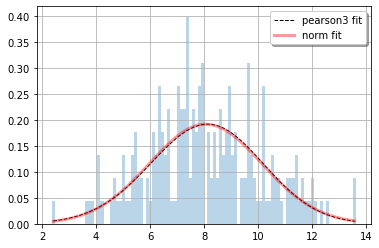

In [13]:
# Worse fit

print("Worse fit cost %f \nNorm cost %f (diff %f)" %(worse_fit[0], worse_fit[4][2], worse_fit[0]-worse_fit[4][2]))
worse_distribution = worse_fit[2]
worse_params = worse_fit[3]

arg = worse_params[:-2]
cdf = lambda val: worse_distribution.cdf(val, loc=worse_params[-2], scale=worse_params[-1], *arg)
worse_cost = compute_cost(cdf, print_sequence=True)
print(worse_cost)

arg = worse_fit[4][1][:-2]
cdf = lambda val: st.norm.cdf(val, loc=worse_fit[4][1][-2], scale=worse_fit[4][1][-1], *arg)
worse_cost = compute_cost(cdf, print_sequence=True)
print(worse_cost)

fig, ax = plt.subplots(1, 1)
# plot the best fit line
ax.plot(x, worse_distribution.pdf(x, loc=worse_params[-2], scale=worse_params[-1], *worse_params[:-2]),
        'k--', lw=1, alpha=1.0, label='%s fit' %(worse_distribution.name))
# plot the normal line
ax.plot(x, st.norm.pdf(x, *worse_fit[4][1]),
        'r-', lw=3, alpha=0.4, label='norm fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()